In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pyemu

setting random seed


## Model background
Here is an example based on the model of Freyberg, 1988.  The synthetic model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg, 1988; the last stress period use 25% less recharge and 25% more pumping.

The inverse problem has 761 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yield, calibration and forecast well flux for each of the six wells, and river bed conductance for each 40 cells with river-type boundary conditions.  The inverse problem has 12 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during both stress periods (observations named ```sw_gw_0``` and ``sw_gw_1``), and the water level in well cell 6 located in at row 28 column 5 at the end of the stress periods (observations named ```or28c05_0``` and ```or28c05_1```).  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

Here we are demostrating the bayes linear estimation capabilities of ```pyemu```.  First we create a ``Schur`` object

In [2]:
jco_file = os.path.join("freyberg","freyberg.jcb")
sc = pyemu.Schur(jco=jco_file)

Then we call ```.get_parameter_summary()``` and set the ``include_map`` flag

In [3]:

par_sum = sc.get_parameter_summary(include_map=True)
par_sum.head()

,post_expt,prior_expt,prior_stdev,post_stdev,is_log
hkr00c00,0.773760,0.774335,0.25,0.249996,True
hkr00c01,0.772436,0.774335,0.25,0.249999,True
hkr00c02,0.770727,0.774335,0.25,0.249992,True
hkr00c03,0.769528,0.774335,0.25,0.249985,True
hkr00c04,0.769993,0.774335,0.25,0.249948,True


``prior_expt`` and ``post_expt`` are the prior and posterior expected values for the parameters and ``prior_stdev`` and ``post_stdev`` are the prior and posterior standard deviations

Similarly, we can use ```get_forecast_summary()``` to get information about the forecast first and second moments

In [4]:
fore_sum = sc.get_forecast_summary(include_map=True)    
fore_sum

,prior_stdev,post_stdev,prior_expt,post_expt
sw_gw_0,282.195029,224.585214,-3809.07710,6413.166479
or28c05_0,0.633264,0.325699,21.18428,8.613202
sw_gw_1,333.988556,333.124994,-971.35140,14271.347941
or28c05_1,0.879440,0.816476,18.25471,2.756905


Then we can use some helpers in ``pyemu`` to generate plots of the prior and posterior assumed normal distributions

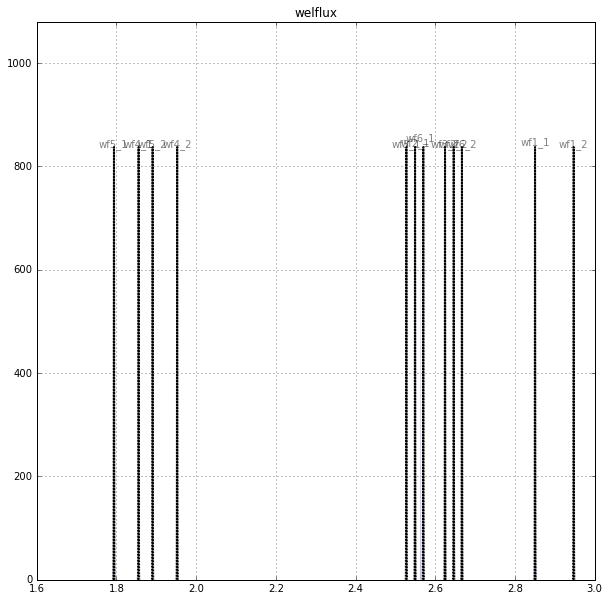

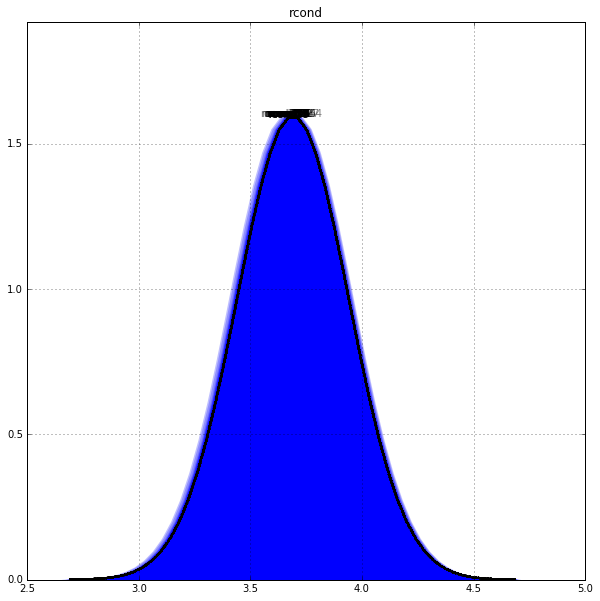

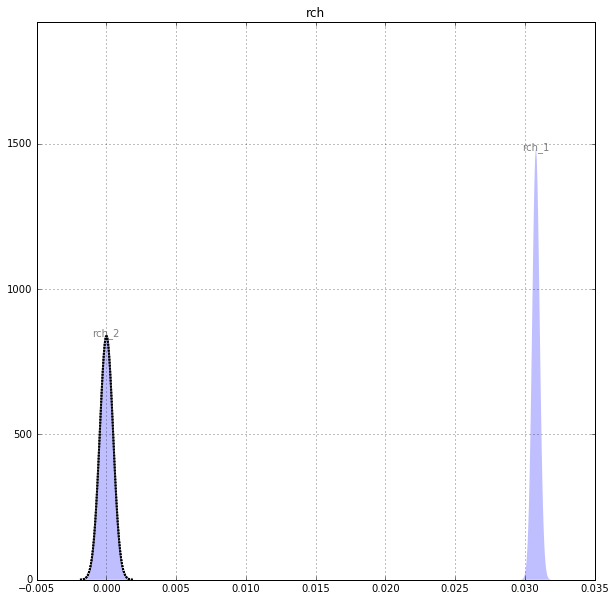

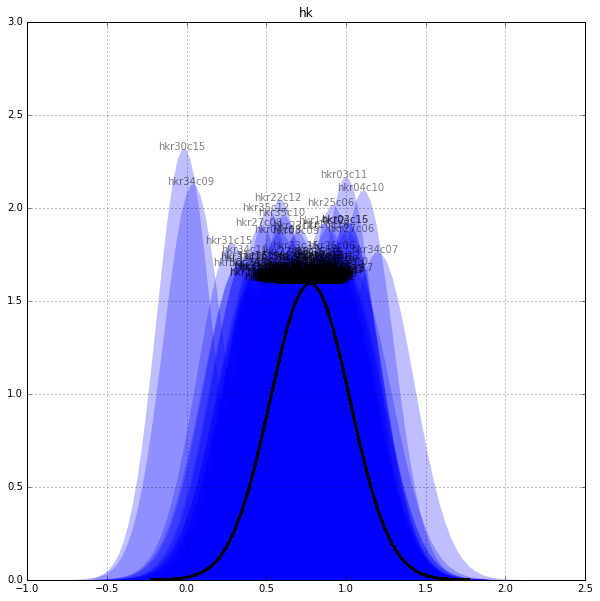

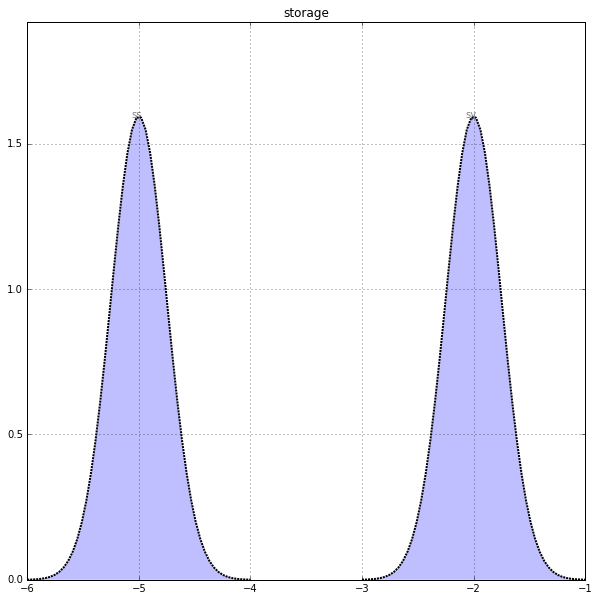

In [5]:
pargp = sc.pst.parameter_data.groupby("pargp").groups
for gp,panmes in pargp.items():
    ax = pyemu.helpers.plot_summary_distributions(par_sum.loc[pargp[gp],:],label_post=True)
    ax.set_title(gp)
    plt.savefig(gp+".pdf")


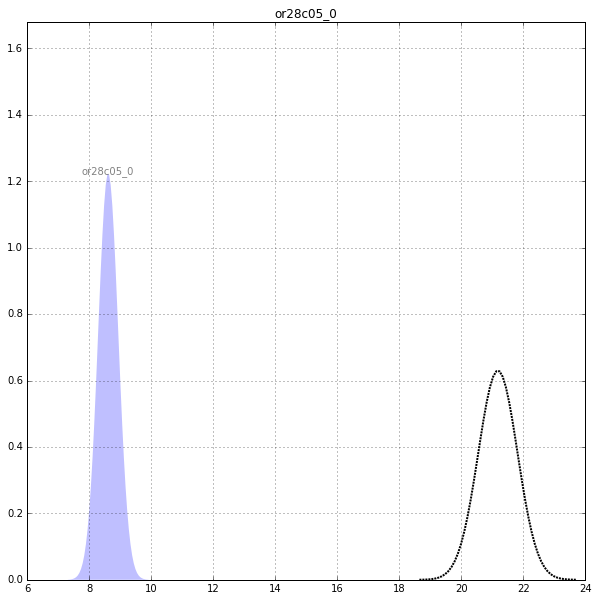

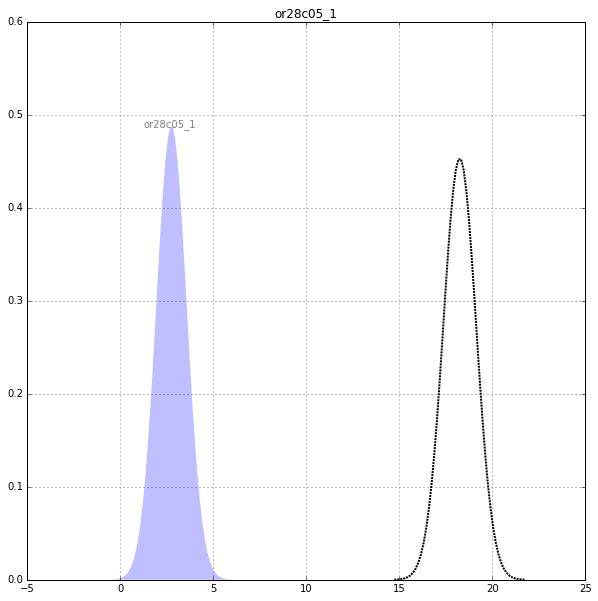

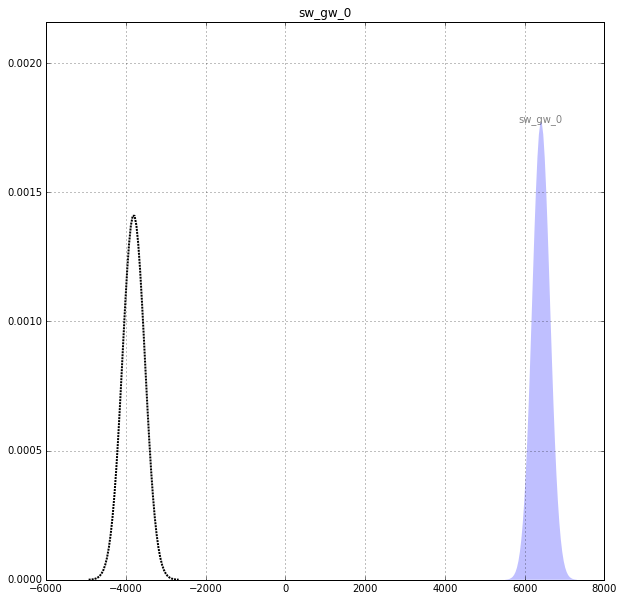

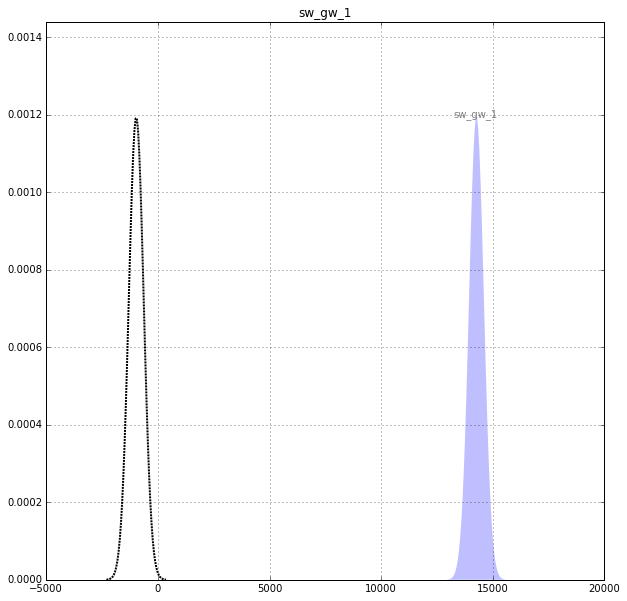

In [6]:
for forecast in sc.forecast_names:
    ax = pyemu.helpers.plot_summary_distributions(fore_sum.loc[[forecast],:],label_post=True)
    ax.set_title(forecast)
    plt.savefig(forecast+".pdf")
    